*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [185]:
# import libraries
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

In [186]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [187]:
train_df = pd.read_csv(train_file_path, sep='\t', names=['is spam', 'text'], header=None)
test_df = pd.read_csv(test_file_path, sep='\t', names=['is spam', 'text'], header=None)

# Visualizing our datasets:

In [188]:
train_df.head()

,is spam,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [189]:
test_df.head()

,is spam,text
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Text(0.5, 1.0, 'Test dataset')

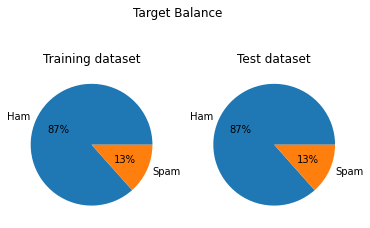

In [190]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Target Balance')
axs[0].pie(train_df['is spam'].value_counts(), labels=['Ham', 'Spam'], autopct='%1.0f%%')
axs[0].set_title('Training dataset')
axs[1].pie(test_df['is spam'].value_counts(), labels=['Ham', 'Spam'], autopct='%1.0f%%')
axs[1].set_title('Test dataset')

Our datasets are equally imbalanced, therefore we'll solve the issue later on by oversampling.

In [191]:
train_df.groupby('is spam')['text'].value_counts()

is spam  text                                                                                                                                                            
ham      sorry, i'll call later                                                                                                                                              22
         ok...                                                                                                                                                                9
         i cant pick the phone right now. pls send a message                                                                                                                  7
         ok                                                                                                                                                                   4
         ok.                                                                                                                  

As we can see, we have duplicated messages, and as far as non-spam messages go, the most reoccurring text is **"sorry i'll call later"**

# Balancing out our datasets:

In [192]:
train_y = train_df.pop('is spam')
test_y = test_df.pop('is spam')

In [193]:
ros = RandomOverSampler(random_state=3)
train_df_balanced, train_y_balanced = ros.fit_resample(train_df, train_y)
test_df_balanced, test_y_balanced = ros.fit_resample(test_df, test_y)

Let's check out how balanced our datasets are after oversampling:

Text(0.5, 1.0, 'Test dataset')

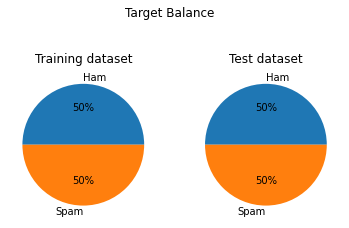

In [194]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Target Balance')
axs[0].pie(train_y_balanced.value_counts(), labels=['Ham', 'Spam'], autopct='%1.0f%%')
axs[0].set_title('Training dataset')
axs[1].pie(test_y_balanced.value_counts(), labels=['Ham', 'Spam'], autopct='%1.0f%%')
axs[1].set_title('Test dataset')

As Thanos would say:

**"Perfectly balanced, as all things should be"** :)

# Checking out text length:

In [195]:
train_df_balanced['text length'] = train_df_balanced['text'].apply(len)
test_df_balanced['text length'] = test_df_balanced['text'].apply(len)

In [196]:
train_df_balanced['text length'].describe().transpose()

count    7238.000000
mean      104.926914
std        56.993395
min         2.000000
25%        51.000000
50%       119.000000
75%       152.000000
max       910.000000
Name: text length, dtype: float64

In [197]:
train_df_balanced[
    train_df_balanced['text length'] == train_df_balanced['text length'].max()
]

,text,text length
1139,for me the love should start with attraction.i...,910


In [198]:
train_y_balanced.loc[1139]

'ham'

In [199]:
train_df_balanced['text length'].mean()

104.9269135120199

Let's verify our vocabulary size:

In [200]:
vec = CountVectorizer()
vec.fit(train_df_balanced['text'])
print(len(vec.vocabulary_))

7445


Now we can set some variables for usage further on:

In [201]:
VOCAB_SIZE = len(vec.vocabulary_)
MAX_LEN = 150

The length of our texts vary a lot, with our longest ham text spanning over 910 characters!

Let's encode our spam labels so we can train our model:

In [202]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_y_balanced = encoder.fit_transform(train_y_balanced)
test_y_balanced = encoder.fit_transform(test_y_balanced)

We need to preprocess our text and we do so by using Keras' Tokenizer:

In [203]:
tokenizer = Tokenizer(num_words=500, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df_balanced['text'])

# Generating sequences and padding:

In [204]:
train_sequences = tokenizer.texts_to_sequences(train_df_balanced['text'])
test_sequences = tokenizer.texts_to_sequences(test_df_balanced['text'])

In [205]:
pad_train_texts = pad_sequences(train_sequences, maxlen=MAX_LEN)
pad_test_texts = pad_sequences(test_sequences, maxlen=MAX_LEN)

# Let's make our Neural Network:

In [206]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Let's see what our model looks like:

In [207]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          238240    
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 246,593
Trainable params: 246,593
Non-trainable params: 0
_________________________________________________________________


In [208]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc']
)

In [209]:
history = model.fit(pad_train_texts, train_y_balanced, epochs=8)

Epoch 1/8
227/227 [==============================] - 8s 31ms/step - loss: 0.2335 - acc: 0.9074
Epoch 2/8
227/227 [==============================] - 7s 33ms/step - loss: 0.0685 - acc: 0.9775
Epoch 3/8
227/227 [==============================] - 7s 33ms/step - loss: 0.0468 - acc: 0.9845
Epoch 4/8
227/227 [==============================] - 7s 32ms/step - loss: 0.0371 - acc: 0.9889
Epoch 5/8
227/227 [==============================] - 7s 33ms/step - loss: 0.0295 - acc: 0.9895
Epoch 6/8
227/227 [==============================] - 8s 33ms/step - loss: 0.0254 - acc: 0.9917
Epoch 7/8
227/227 [==============================] - 7s 32ms/step - loss: 0.0222 - acc: 0.9934
Epoch 8/8
227/227 [==============================] - 7s 32ms/step - loss: 0.0190 - acc: 0.9920


We've hit an accuracy of 99% percent, meaning our model almost definitely overfit. Let's evaluate it:

In [210]:
results = model.evaluate(pad_test_texts, test_y_balanced)
print(results)

76/76 [==============================] - 1s 10ms/step - loss: 0.3070 - acc: 0.9344
[0.3069645166397095, 0.9344398379325867]


Let's make a new model and add a few different layers in order to avoid overfitting:

In [242]:
model = tf.keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [243]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          119120    
                                                                 
 global_average_pooling1d_6   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 119,697
Trainable params: 119,697
Non-trainable params: 0
________________________________________________

We've added a pooling layer after embedding in order to avoid overfitting. We then replace our LSTM layer with a Dense layer consisting of 32 neurons. Finally we add a Dropout layer before our final layer, again, in order to avoid overfitting.

Now let's see if we run into our fitting issue again:

In [244]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['acc']
)

In [245]:
history = model.fit(pad_train_texts, train_y_balanced, epochs=8)

Epoch 1/8
227/227 [==============================] - 1s 1ms/step - loss: 0.6587 - acc: 0.7267
Epoch 2/8
227/227 [==============================] - 0s 1ms/step - loss: 0.4148 - acc: 0.9127
Epoch 3/8
227/227 [==============================] - 0s 1ms/step - loss: 0.1885 - acc: 0.9417
Epoch 4/8
227/227 [==============================] - 0s 1ms/step - loss: 0.1166 - acc: 0.9599
Epoch 5/8
227/227 [==============================] - 0s 2ms/step - loss: 0.0894 - acc: 0.9686
Epoch 6/8
227/227 [==============================] - 0s 1ms/step - loss: 0.0769 - acc: 0.9733
Epoch 7/8
227/227 [==============================] - 0s 1ms/step - loss: 0.0681 - acc: 0.9769
Epoch 8/8
227/227 [==============================] - 0s 1ms/step - loss: 0.0631 - acc: 0.9793


In [246]:
results = model.evaluate(pad_test_texts, test_y_balanced)

76/76 [==============================] - 0s 716us/step - loss: 0.0980 - acc: 0.9680


In [254]:
print(results)

[0.09804507344961166, 0.9680497646331787]


In [247]:
def encode_text(text):
    text_tokens = keras.preprocessing.text.text_to_word_sequence(text)
    text_tokens = [tokenizer.word_index[token] if token in tokenizer.word_index else 0 for token in text_tokens]
    padded_text = pad_sequences([text_tokens], MAX_LEN)[0]
    return padded_text

In [248]:
encode_text('what an amazing life this is')

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  77, 129, 982, 301,  30,  11])

Our encoding function seems to work as intended!
Now let's make its counterpart, a decoding function:

In [249]:
def decode_text(sequence):
    text = []
    for code in sequence:
        if code != 0:
            for key, value in tokenizer.word_index.items():
                if value == code:
                    text.append(key)
    text = ' '.join(text)
    return text

In [250]:
decode_text([77, 129, 982, 301, 30, 11])

'what an amazing life this is'

Now that we have our functions for dealing with text encoding and decoding, let's get to some predictions:

In [251]:
def predict_spam(text):
    encoded_text = encode_text(text=text)
    prediction = np.zeros((1, MAX_LEN))
    prediction[0] = encoded_text
    result = model.predict(prediction)
    print(result)

In [258]:
predict_spam('i cant pick the phone right now. pls send a message')

1/1 [==============================] - 0s 15ms/step
[[0.0264499]]


## These last 2 cells are for grading, I did not make these.

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  


  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()
